In [14]:
import pandas as pd
import numpy as np
from numpy import isnan
from collections import Counter
from sklearn.metrics import confusion_matrix

from random import randint

import matplotlib.pyplot as plt

from computeNutriScore import computeNutriScore

%run Data_scrapping_USagriculture.ipynb

DATA_FOLDER = './data/'

In [15]:
# Load Data and Clean
data_raw = pd.read_csv(DATA_FOLDER + 'en.openfoodfacts.org.products.csv', delimiter = '\t', low_memory = False)
data_clean = data_raw.copy()

# Drop duplicates according to the code
data_clean.drop_duplicates(subset = 'code', keep = False, inplace = True)
data_clean.set_index('code', inplace = True)

# Drop product without product name and without tags
data_clean = data_clean[~data_clean.product_name.isna() & ~data_clean.categories_tags.isna()]

In [16]:
# Create 2 DataFrame - one for only food (useful for compute NutriScore) and an other one with the left columns
column_for_data_food = ['product_name','categories_tags','energy_100g','fat_100g','saturated-fat_100g',
                                            'sugars_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g',
                                            'fruits-vegetables-nuts-estimate_100g','fiber_100g','proteins_100g']

data_food = data_clean[column_for_data_food]

data_clean.drop(column_for_data_food, axis = 1, inplace = True)


In [17]:
data_food.describe(percentiles = [.25, .50, .75, .99])

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,1.480730e+05,146533.000000,143766.000000,144222.000000,142788.000000,142785.000000,2939.000000,7466.000000,7.827000e+04,147298.000000
mean,1.200323e+03,14.601458,5.781768,16.718755,2.549246,1.003761,43.438452,43.996718,7.116702e+04,7.481971
std,1.284265e+04,190.279516,51.635586,342.593733,146.659602,57.742793,33.508329,29.703503,1.990937e+07,52.067622
min,0.000000e+00,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-6.670000e+00,-5.560000
25%,3.470000e+02,0.500000,0.100000,1.000000,0.030000,0.011811,12.000000,14.000000,0.000000e+00,0.900000
50%,9.950000e+02,5.700000,1.690000,4.500000,0.356000,0.140000,43.000000,50.000000,1.500000e+00,5.100000
75%,1.648000e+03,21.200000,7.400000,19.000000,1.168400,0.460000,65.000000,63.000000,3.400000e+00,9.700000
99%,3.700000e+03,93.300000,45.000000,82.000000,11.073900,4.358545,100.000000,100.000000,2.000000e+01,30.900000
max,2.790000e+06,66700.000000,10000.000000,86700.000000,50800.000000,20000.000000,100.000000,100.000000,5.570000e+09,11800.000000


In [18]:
def Complete_ratio_column(df):
    for column in df.columns:
        ratio = len(df[[column]].dropna()) * 100/len(df)
        print("For {}, {} % is complete".format(column, round(ratio, 3)))
        
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 86.001 % is complete
For fat_100g, 85.107 % is complete
For saturated-fat_100g, 83.5 % is complete
For sugars_100g, 83.765 % is complete
For salt_100g, 82.932 % is complete
For sodium_100g, 82.93 % is complete
For fruits-vegetables-nuts_100g, 1.707 % is complete
For fruits-vegetables-nuts-estimate_100g, 4.336 % is complete
For fiber_100g, 45.46 % is complete
For proteins_100g, 85.551 % is complete


In [19]:
# Put NaN for incoherent values
def Coherent_value(df):
    """ Compute coherent value for food values """
    for i in range(len(df)):
        # energy
        value = df.iat[i, 2]
        if  value < 0 or value > 4000:
            df.iat[i, 2] = np.nan
        
        #other column
        for column in range(3, len(df.columns)):
            value = df.iat[i, column]
            if (value < 0) or (value > 100):
                df.iat[i, column] = np.nan
    return df

data_food = Coherent_value(data_food)

In [20]:
data_food.describe()

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,147879.000000,146489.000000,143742.000000,144151.000000,142650.000000,142680.000000,2939.000000,7466.000000,78241.000000,147262.000000
mean,1090.190054,13.714214,5.403005,13.973513,1.115041,0.453263,43.438452,43.996718,2.703701,7.017626
std,826.969127,18.868590,8.866378,19.734165,4.775650,2.117850,33.508329,29.703503,4.547284,7.920598
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,347.000000,0.500000,0.100000,1.000000,0.030000,0.011811,12.000000,14.000000,0.000000,0.900000
50%,992.000000,5.700000,1.680000,4.500000,0.350000,0.139382,43.000000,50.000000,1.500000,5.100000
75%,1644.000000,21.100000,7.400000,19.000000,1.150620,0.456693,65.000000,63.000000,3.400000,9.700000
max,3987.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [21]:
all_tags = [tags.split(',') for tags in list(data_food[['categories_tags']].dropna().categories_tags)]

list_tags = []
for tags in all_tags:
    for tag in tags:
        list_tags.append(tag)
        
dic_tag = dict(Counter(list_tags).most_common())

In [22]:
def relevant_tag(dic, tags, threshold = 5):
    """ Return the least frequent tag from the list, who however has more than 'threshold' 
    correspondancies in the database """
    dict_ = {}
    sort = []
    
    for tag in tags:
        dict_[tag] = dic[tag]
        
    dict_ = {k: v for k, v in dict_.items() if v >= threshold}
    if len(dict_) > 0:
        sort = sorted(dict_, key=dict_.get, reverse=False)
        return sort
    else :
        return None

In [23]:
data_food_left = data_food[(data_food.isnull().sum(axis=1) == 10) & ~(data_food.categories_tags.str.contains('beverages', case = False))]

list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])

dict(Counter(list_tag).most_common())
    

{'en:dietary-supplements': 141,
 'en:honeys': 113,
 'en:cheeses': 105,
 'en:yogurts': 87,
 'en:candies': 83,
 'en:biscuits': 83,
 'en:chocolates': 79,
 'en:free-range-eggs': 69,
 'en:sauces': 66,
 'fr:miels-d-acacia': 66,
 'en:dark-chocolates': 65,
 'en:mustards': 57,
 'en:eggs': 56,
 'en:chicken-breasts': 56,
 'en:cakes': 49,
 'en:honeys-from-france': 48,
 'fr:miels-cremeux': 48,
 'en:groceries': 46,
 'en:prepared-meats': 42,
 'en:crackers': 41,
 'en:beef': 41,
 'en:pastries': 41,
 'fr:miels-de-fleurs': 41,
 'en:condiments': 39,
 'fr:foies-gras-entiers': 38,
 'fr:tuiles-salees': 36,
 'en:fresh-meats': 36,
 'en:sausages': 34,
 'en:milk-chocolates': 33,
 'en:food-colorings': 33,
 'en:vinegars': 33,
 'en:pork': 32,
 'en:dried-meals': 32,
 'en:milks': 32,
 'en:bieres': 32,
 'en:salts': 32,
 'en:cage-eggs': 32,
 'en:white-hams': 30,
 'en:balsamic-vinegars-of-modena': 30,
 'en:cocoa-powder': 29,
 'en:bonbons': 29,
 'en:ketchup': 27,
 'en:chocolate-biscuits': 27,
 'en:confectioneries': 27,
 

In [24]:
data_food = data_food[~(data_food.isnull().sum(axis=1) == 10) | 
                      (data_food.categories_tags.str.contains('beverages', case = False))]
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 91.328 % is complete
For fat_100g, 90.469 % is complete
For saturated-fat_100g, 88.773 % is complete
For sugars_100g, 89.026 % is complete
For salt_100g, 88.099 % is complete
For sodium_100g, 88.117 % is complete
For fruits-vegetables-nuts_100g, 1.815 % is complete
For fruits-vegetables-nuts-estimate_100g, 4.611 % is complete
For fiber_100g, 48.32 % is complete
For proteins_100g, 90.947 % is complete


In [25]:
data_food_left = data_food[data_food.fiber_100g.isna()]

list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])

dict(Counter(list_tag).most_common())
    

{'en:non-alcoholic-beverages': 2164,
 'en:sugared-beverages': 869,
 'en:fats': 820,
 'en:dark-chocolates': 703,
 'en:milks': 554,
 'en:beers': 505,
 'en:candies': 478,
 'en:white-hams': 473,
 'en:biscuits': 422,
 'en:artificially-sweetened-beverages': 350,
 'en:milk-chocolates': 335,
 'en:cheeses': 321,
 'en:non-sugared-beverages': 317,
 'en:extra-virgin-olive-oils': 316,
 'en:yogurts': 307,
 'en:ketchup': 301,
 'en:gelified-candies': 299,
 'en:squeezed-apple-juices': 266,
 'en:chocolates': 263,
 'en:sauces': 261,
 'en:strawberry-jams': 248,
 'en:coffees': 241,
 'en:spices': 236,
 'en:lagers': 232,
 'en:bonbons': 229,
 'en:cakes': 221,
 'en:sodas': 218,
 'en:shortbread-cookies': 214,
 'en:red-wines': 211,
 'en:colas': 209,
 'en:goat-cheeses': 207,
 'en:crackers': 206,
 'en:apricot-jams': 205,
 'en:mayonnaises': 203,
 'en:cocoa-and-hazelnuts-spreads': 197,
 'en:ground-coffees': 190,
 'en:teas': 190,
 'en:fruit-based-beverages': 189,
 'en:smoked-salmons-from-farming': 188,
 'fr:fromages-

In [33]:
def nearest_neighbor_product(product, df, dic_tag):
    ''' product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    # Check if the product need to be fill
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        # Sort the tags of the product from the less used to the more used in the dataframe
        tags = product.categories_tags[0].split(',')
        tag_sorted = relevant_tag(dic_tag, tags, 3)
        
        if tag_sorted != None:
            
            # iterate on each tag to complete
            for tag_i in range(len(tag_sorted)):
                tag = tag_sorted[tag_i]
                
                # Take product on the same 'type' as the product we want to fill
                df_for_average = df[df.categories_tags.str.contains(tag, case = False)]
                for j in range(2,len(product_fill.columns)):
                    
                    # the column need to be fill
                    if str(product_fill.iat[0, j]) == 'nan':
                        df_for_average_ = df_for_average[product_fill.columns[j]].copy()
                        df_for_average_.dropna(axis=0, inplace = True)
                        
                        # the same products have values
                        if len(df_for_average_) > 0:
                            product_fill.iat[0, j] = np.median(df_for_average[product_fill.columns[j]].\
                                                               dropna(axis=0).tolist())
                        # it's the last tag
                        elif tag_i == (len(tag_sorted) - 1):
                            # if the same product doesn't have values, we take the values of the entire dataframe
                            data_all = df[product_fill.columns[j]].dropna(axis=0).copy()
                            if len(data_all) > 0:
                                product_fill.iat[0, j] = np.median(data_all.tolist())
                            else:
                                # Your data frame doesn't have at least one value 
                                raise NameError('Your entire data_frame do not have values for : {}'.\
                                                format(product_fill.columns[j]))
                            
                    if product_fill.isnull().sum(axis=1)[0] == 0:
                        break
                        
                if product_fill.isnull().sum(axis=1)[0] == 0:
                        break
        else:
            for j in range(1,len(product_fill.columns)):
                product_fill.iat[0, j] = np.median(df[product_fill.columns[j]].dropna().tolist())
            
    return product_fill

In [70]:
product = data_food.iloc[[randint(0, len(data_food))]].copy()

product

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3760134372387,Mochi Coconut Ice Cream,"en:desserts,en:frozen-foods,en:frozen-desserts",929.0,5.5,3.8,22.0,0.11,0.043307,NaN,NaN,NaN,0.0


In [71]:
nearest_neighbor_product(product, data_food, dic_tag)

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3760134372387,Mochi Coconut Ice Cream,"en:desserts,en:frozen-foods,en:frozen-desserts",929.0,5.5,3.8,22.0,0.11,0.043307,49.5,40.8,0.8,0.0


In [60]:
def fill_from_Api(product):
    '''product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        query = product.product_name[0]
        query = query.replace('è', 'e')
        query = query.replace('é', 'e')
        query = query.replace('ü', 'u')
        query = query.replace('ö', 'o')
        query = query.replace('à', 'a')
        query = query.replace('ä', 'a')
        query = query.replace('£', '')
        query = query.replace('ç', '')
    
        dic = scrap(query_ = query)
        tags = product.categories_tags[0]
        code = product.index[0]
        columns = {
            'Name' : 'product_name',
            'kJ' : 'energy_100g',
            'Proteins': 'proteins_100g',
            'Sugars' : 'sugars_100g',
            'Sat_fats' : 'saturated-fat_100g',
            'Fibers': 'fiber_100g',
            'Sodium': 'sodium_100g',
            'Lipids' : 'fat_100g',
            'Fruit_Veg_content' : 'fruits-vegetables-nuts-estimate_100g'
        }

        column_for_product = ['product_name','categories_tags','energy_100g','fat_100g','saturated-fat_100g',
                                                'sugars_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g',
                                                'fruits-vegetables-nuts-estimate_100g','fiber_100g','proteins_100g']
        dic['code'] = code
        dic['categories_tags'] = tags
        dic['Sodium'] = dic['Sodium']*0.001 #mg -> g
        dic['salt_100g'] = dic['Sodium']*2.5
        if dic['Fruit_Veg_content'] == 1:
            dic['Fruit_Veg_content'] = 100
        dic['fruits-vegetables-nuts_100g'] = np.nan
        product_fill = pd.DataFrame(data = dic, index = ['0']).set_index('code')
        product_fill.rename(columns=columns, inplace=True)
    
        return product_fill[column_for_product]
    
    else :
        return product_fill

In [72]:
fill_from_Api(product)

https://api.nal.usda.gov/ndb/search/?format=json&q=Mochi%20Coconut%20Ice%20Cream&max=20&sort=r&offset=0&ds=Standard%20Reference&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv
https://api.nal.usda.gov/ndb/reports/?ndbno=04659&type=b&format=json&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv


,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3760134372387,"Oil, industrial, coconut, confection fat, typi...","en:desserts,en:frozen-foods,en:frozen-desserts",3698.656,100.0,86.503,0.0,0.0125,0.005,NaN,0,0.0,0.0


In [73]:
def User_fill(product):
    '''product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    if product_fill.isnull().sum(axis=1)[0] > 0:
        print("Please fill the following question for {}".format(product_fill.product_name[0]))
        for index in range(2, len(product_fill.columns)):
            
            if str(product_fill.iat[0, index]) == 'nan':
                while True:
                    value  = float(input("Value for {} : ".format(product_fill.columns[index])))
                    if (product_fill.columns[index] == 'energy_100g') & (value >= 0) & (value <= 4000):
                        product_fill.iat[0, index] = value
                        break
                    elif (product_fill.columns[index] != 'energy_100g') & (value >= 0) & (value <= 100):
                        product_fill.iat[0, index] = value
                        break
                    else:
                        print('Please put a coherant value !')
               
    return product_fill
    

In [74]:
User_fill(product)

Please fill the following question for Mochi Coconut Ice Cream
Value for fruits-vegetables-nuts_100g : 0
Value for fruits-vegetables-nuts-estimate_100g : 0
Value for fiber_100g : 2.0


,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3760134372387,Mochi Coconut Ice Cream,"en:desserts,en:frozen-foods,en:frozen-desserts",929.0,5.5,3.8,22.0,0.11,0.043307,0.0,0.0,2.0,0.0


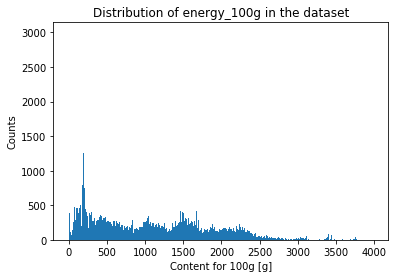

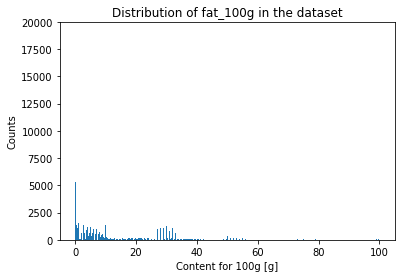

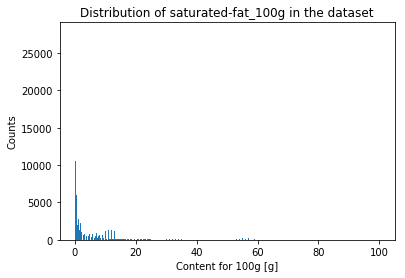

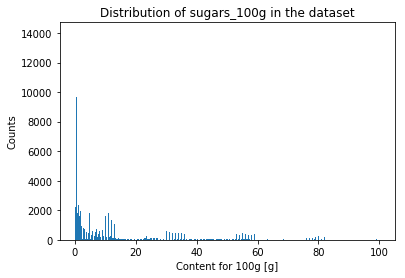

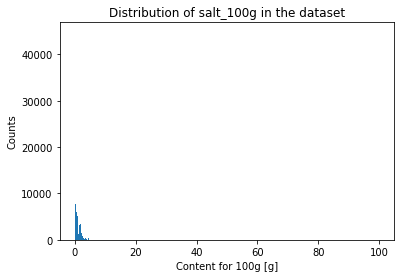

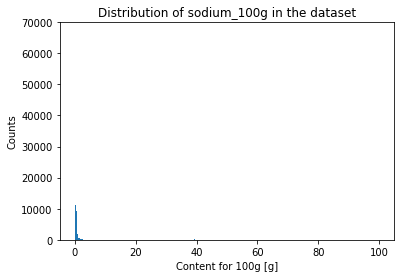

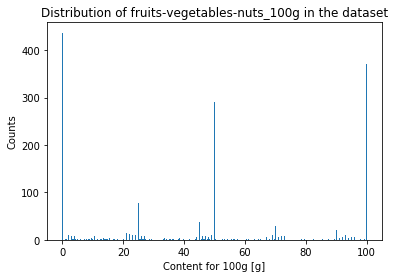

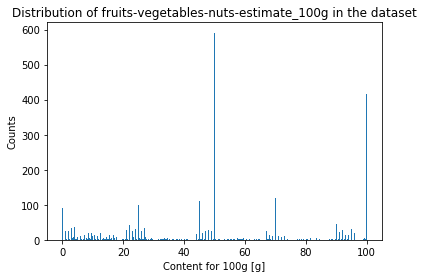

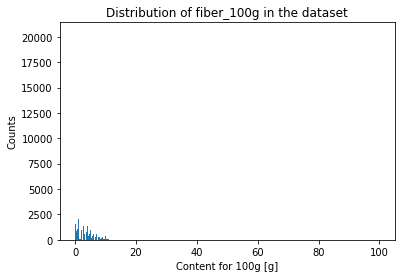

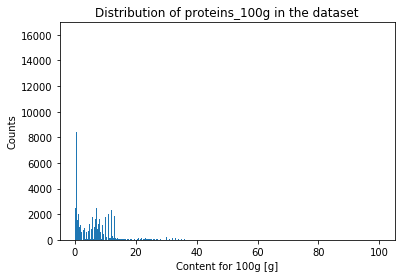

In [99]:
for index in range(2, len(data_food.columns)):
    column = data_food.columns[index]
    plt.hist(data_food[column], bins = 1000);
    plt.title('Distribution of {} in the dataset'.format(column));
    plt.ylabel('Counts');
    plt.xlabel('Content for 100g [g]')
    plt.show()

In [102]:
data_food.corr(method ='pearson')

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
energy_100g,1.000000,0.808848,0.615164,0.291457,-0.035914,-0.034936,-0.165504,-0.182315,0.242768,0.221476
fat_100g,0.808848,1.000000,0.730007,-0.057889,-0.008345,-0.009628,-0.165285,-0.182469,0.064806,0.138259
saturated-fat_100g,0.615164,0.730007,1.000000,0.042599,-0.012461,-0.012096,-0.221458,-0.312151,0.022232,0.141980
sugars_100g,0.291457,-0.057889,0.042599,1.000000,-0.086998,-0.078013,0.081503,0.088097,0.026772,-0.235284
salt_100g,-0.035914,-0.008345,-0.012461,-0.086998,1.000000,1.000000,-0.103775,-0.055245,-0.004394,0.067489
sodium_100g,-0.034936,-0.009628,-0.012096,-0.078013,1.000000,1.000000,-0.103773,-0.055242,-0.004556,0.059537
fruits-vegetables-nuts_100g,-0.165504,-0.165285,-0.221458,0.081503,-0.103775,-0.103773,1.000000,0.998090,0.104843,-0.212345
fruits-vegetables-nuts-estimate_100g,-0.182315,-0.182469,-0.312151,0.088097,-0.055245,-0.055242,0.998090,1.000000,0.096676,-0.211749
fiber_100g,0.242768,0.064806,0.022232,0.026772,-0.004394,-0.004556,0.104843,0.096676,1.000000,0.251992
proteins_100g,0.221476,0.138259,0.141980,-0.235284,0.067489,0.059537,-0.212345,-0.211749,0.251992,1.000000


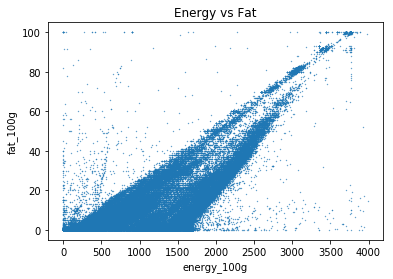

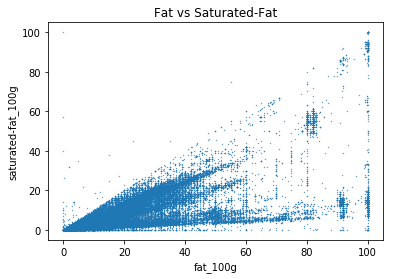

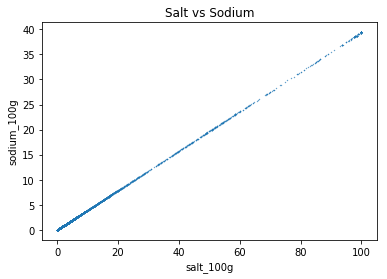

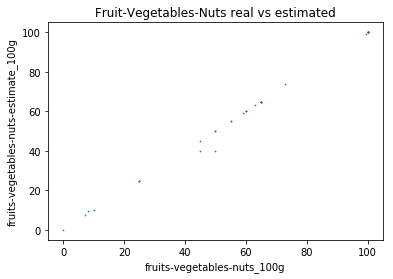

In [117]:
plt.scatter(data_food['energy_100g'],data_food['fat_100g'], s=0.1);
plt.title('Energy vs Fat');
plt.ylabel('fat_100g');
plt.xlabel('energy_100g');
plt.show()

plt.scatter(data_food['fat_100g'],data_food['saturated-fat_100g'], s=0.1);
plt.title('Fat vs Saturated-Fat');
plt.ylabel('saturated-fat_100g');
plt.xlabel('fat_100g');
plt.show()

plt.scatter(data_food['salt_100g'],data_food['sodium_100g'], s=0.1);
plt.title('Salt vs Sodium');
plt.ylabel('sodium_100g');
plt.xlabel('salt_100g');
plt.show()

plt.scatter(data_food['fruits-vegetables-nuts_100g'],data_food['fruits-vegetables-nuts-estimate_100g'], s=0.5);
plt.title('Fruit-Vegetables-Nuts real vs estimated');
plt.ylabel('fruits-vegetables-nuts-estimate_100g');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.show()

In [118]:
data_nutriscore = data_clean[['nutrition-score-fr_100g','nutrition_grade_fr']]

data_food_nutri = data_food.join(data_nutriscore)

data_food_nutri = data_food_nutri[~data_food_nutri.nutrition_grade_fr.isna()]

data_food_nutri['Predicted_NutriScore_grade'] = np.nan
data_food_nutri['Predicted_NutriScore_score'] = np.nan

for index in range(len(data_food_nutri)):

    product = data_food_nutri.iloc[[index]]
    nutriscore, final_score = computeNutriScore(product)
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_grade'] = nutriscore
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_score'] = final_score

y_true = data_food_nutri['nutrition_grade_fr']
y_pred = data_food_nutri['Predicted_NutriScore_grade']
confusion_matrix(y_true, y_pred, labels=['a', 'b', 'c', 'd', 'e', 'Error'])

array([[14527,   198,    11,    13,    10,  3963],
       [  568, 11188,   359,    58,    56,  6762],
       [  285,   124, 16410,   335,    32, 10815],
       [   90,    51,  1223, 18118,   220, 19621],
       [  148,    69,   452,   370, 16318, 13393],
       [    0,     0,     0,     0,     0,     0]], dtype=int64)

In [119]:
ratio_grade = len(data_food_nutri[data_food_nutri['nutrition_grade_fr'] == data_food_nutri['Predicted_NutriScore_grade']])*\
    100 / len(data_food_nutri)
ratio_score = len(data_food_nutri[data_food_nutri['nutrition-score-fr_100g'] == data_food_nutri['Predicted_NutriScore_score']])*\
    100 / len(data_food_nutri)

print('The accuracy according to the grade is {} %, the accuracy according to the score is {} %.'.\
          format(ratio_grade,ratio_score))

The accuracy according to the grade is 56.3831589180113 %, the accuracy according to the score is 51.83780479721917 %.
